In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from utils import get_data

results_df = None

from sklearn.preprocessing import MinMaxScaler

def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency']])
    normalized_count = normalized_values[:, 0]
    normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data['d_ln_open_price'], label='Actual d_ln_open_price', color='blue', marker='o')
    plt.scatter(test_data.index, predictions, label='Predicted d_ln_open_price', color='red', marker='x')
    plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def get_stats(model_fit, test_data, test_exog):
    predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
    mse = mean_squared_error(test_data['d_ln_open_price'], predictions)
    rmse = np.sqrt(mse)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    
    return {
        'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }

# Adjust the model estimation to use the differenced series
def model_estimation(df, p_range, q_range, title='Model Estimation', ratio=0.8):
    global results_df
    results = []
    train_size = int(len(df) * ratio)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    cols = ['d_ln_avg_efficiency']  #, 'count' ,'time']
    train_exog, test_exog = add_constant(train_data[cols], test_data[cols])

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                mean_baseline_mae = []
                prev_value_baseline_mae = []
                for start in range(0, len(train_data) - 10, 5):  # Adjust these values as needed
                    end = start + 10  # Adjust for the size of the window
                    rolling_train = train_data.iloc[start:end]
                    rolling_test = train_data.iloc[end:end + 1]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[cols], rolling_test[cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train['d_ln_open_price'])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test['d_ln_open_price'], [mean_pred]))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train['d_ln_open_price'].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test['d_ln_open_price'], [prev_value_pred]))

                    # Baseline 3: no exog
                    rolling_train_exog, rolling_test_exog = np.random.rand(len(rolling_train), 1)*10000, np.random.rand(len(rolling_test), 1)*10000

                    # Baseline 4: give the model the solution
                    # rolling_train_exog, rolling_test_exog = np.array(rolling_train['d_ln_avg_efficiency'].tolist()[1:] + [0]).reshape(-1, 1), np.array(rolling_test['d_ln_avg_efficiency'].tolist()).reshape(-1, 1)
                    
                    # ARIMA Model
                    model = ARIMA(rolling_train['d_ln_open_price'], order=(p, 0, q), exog=rolling_train_exog)
                    model_fit = model.fit()
                    print(model_fit.summary())
                    predictions = model_fit.forecast(steps=1, exog=rolling_test_exog)
                    mae = mean_absolute_error(rolling_test['d_ln_open_price'], predictions)
                    rolling_mae.append(mae)
                    break
                
                avg_mae = np.mean(rolling_mae)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MAE'])
    print(f"Mean Baseline MAE: {results[0]['Mean Baseline MAE']}")
    print(f"Previous Value Baseline MAE: {results[0]['Prev Value Baseline MAE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        print(f"Top {i+1} Model: ARIMA({p},0,{q}), MAE: {results[i]['MAE']}")
        # Fit the model on the entire training dataset
        model = ARIMA(train_data['d_ln_open_price'], order=(p, 0, q), exog=train_exog)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
        print(get_stats(model_fit, test_data, test_exog))
        plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")



In [37]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = df[['d_ln_avg_efficiency', 'd_ln_open_price']]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in ['d_ln_avg_efficiency', 'd_ln_max_efficiency']:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=18, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=18, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    return score, p_value, crit_value


In [38]:
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

# Quaterly

Quarterly Data Model Estimation:
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   10
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   5.401
Date:                Fri, 22 Mar 2024   AIC                             -0.802
Time:                        21:34:08   BIC                              0.711
Sample:                    03-31-2015   HQIC                            -2.462
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394      0.220      0.179      0.858      -0.391       0.470
x1          2.354e-05   2.78e-05      0.846      0.398    -3.1e-05    7.81e-05
ar.L1          0.08

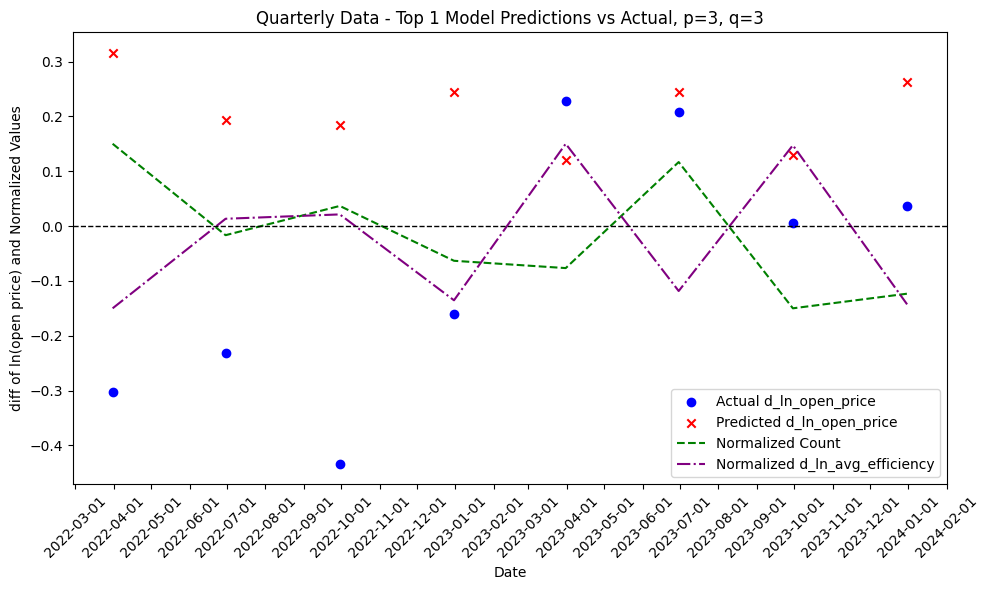

Top 2 Model: ARIMA(2,0,2), MAE: 0.06965925218379299
{'MSE': 0.1506594681279035, 'RMSE': 0.38814877061238195, 'AIC': 21.101545075309552, 'BIC': 30.42697664653598, 'Ljung-Box': 0.5229621100674304, 'Durbin-Watson': 1.9290849566894108, 'Jarque-Bera': 0.25801951986299004, 'Shapiro-Wilk': 0.10305473208427429, 'White Test': 0.5708716159141405}


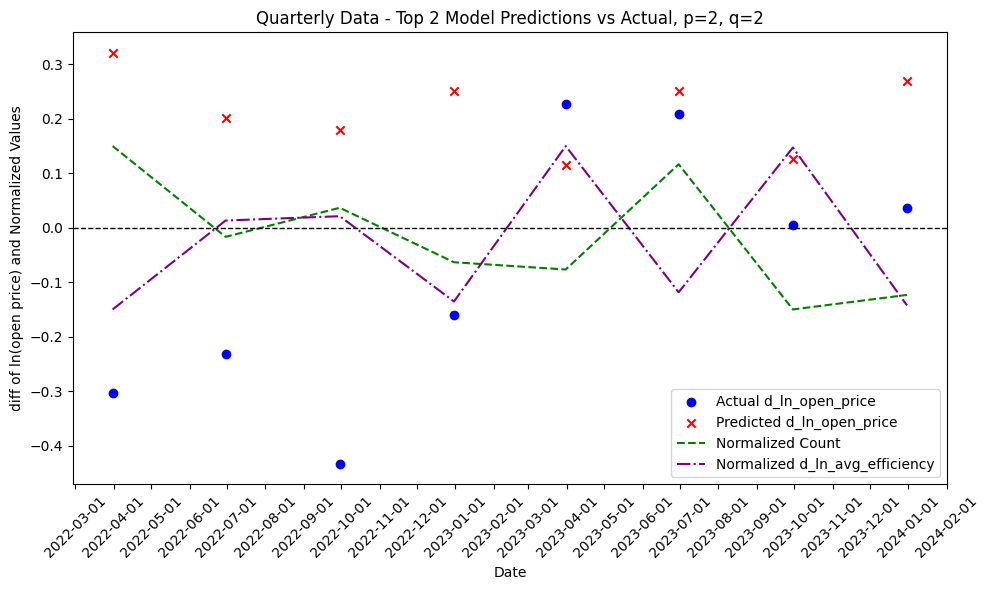

Top 3 Model: ARIMA(3,0,1), MAE: 0.12944250321477552
{'MSE': 0.15177479996179596, 'RMSE': 0.389582853783115, 'AIC': 21.147728715666183, 'BIC': 30.47316028689261, 'Ljung-Box': 0.5115479537702043, 'Durbin-Watson': 1.9135156181484891, 'Jarque-Bera': 0.2728238675416394, 'Shapiro-Wilk': 0.10682480782270432, 'White Test': 0.60025588162056}


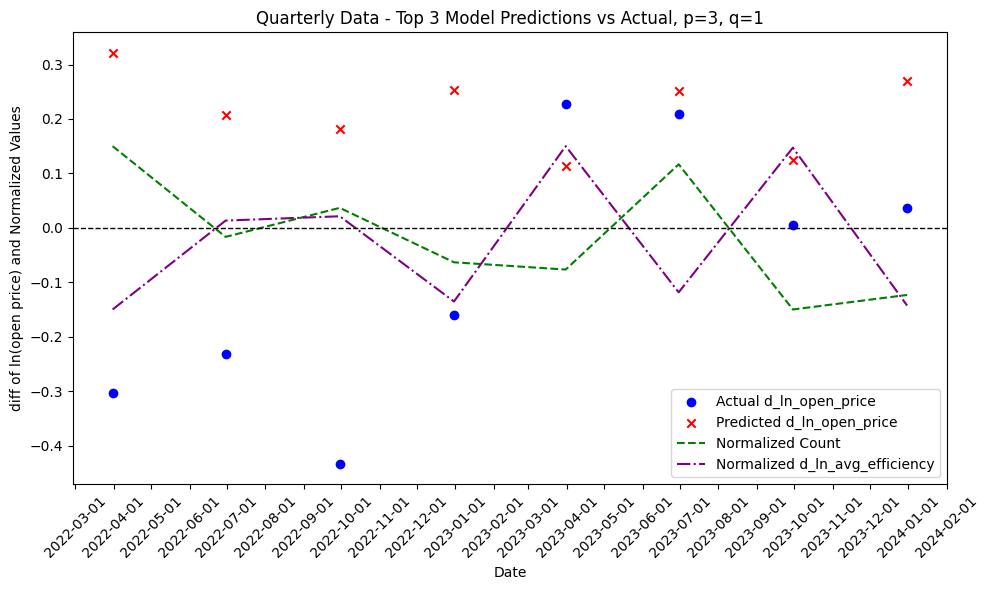

In [39]:
print("Quarterly Data Model Estimation:")
model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), title='Quarterly Data', ratio=0.8)
results_df

In [21]:
print("Stationarity Check for Quarterly Data:")
check_stationarity(quarterly_data['d_ln_open_price'])
check_stationarity(quarterly_data['d_ln_avg_efficiency'])

Stationarity Check for Quarterly Data:
ADF Statistic: -3.775273
p-value: 0.003171
Series is stationary
ADF Statistic: -8.339243
p-value: 0.000000
Series is stationary


Distribution Plot:


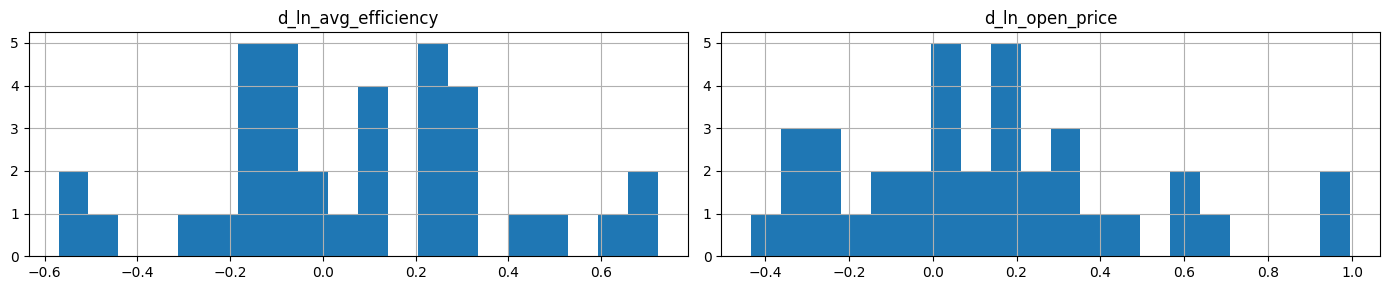

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


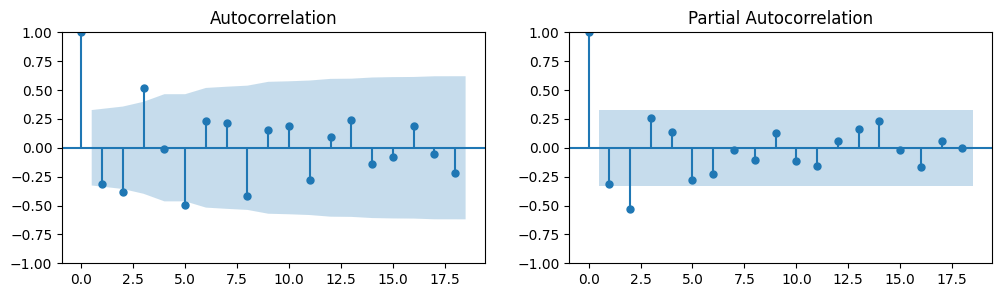

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,36.0,0.073419,0.315846,-0.569873,-0.136739,0.077264,0.273398,0.721643,0.075130,-0.140035
d_ln_open_price,36.0,0.130219,0.346101,-0.433166,-0.114683,0.100708,0.290912,0.995362,0.748462,0.523040


In [22]:
exploratory_analysis(quarterly_data)

In [23]:
perform_cointegration_test(quarterly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -3.638660237284447
p-value: 0.02192804059767351
Critical values: [-4.23672041 -3.51627408 -3.16784755]
The series are likely co-integrated.


(-3.638660237284447,
 0.02192804059767351,
 array([-4.23672041, -3.51627408, -3.16784755]))

# Monthly

In [24]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(2, 6, 1), range(2, 6, 1), title='Monthly Data', ratio=0.8)
# model_estimation(monthly_data, range(4, 7, 1), range(4, 7, 1), title='Monthly Data', ratio=0.8)
# model_estimation(monthly_data, range(1, 3, 1), range(1, 3, 1), title='Monthly Data', ratio=0.8)
results_df

Monthly Data Model Estimation:


In [ ]:
print("Stationarity check for monthly data")
check_stationarity(monthly_data['d_ln_open_price'])
check_stationarity(monthly_data['d_ln_avg_efficiency'])

Stationarity check for monthly data
ADF Statistic: -6.910087
p-value: 0.000000
Series is stationary
ADF Statistic: -6.329888
p-value: 0.000000
Series is stationary


Distribution Plot:


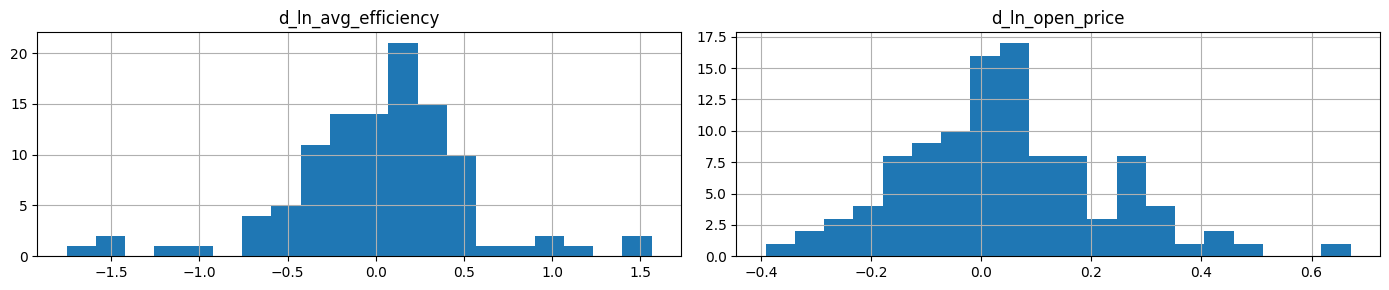

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


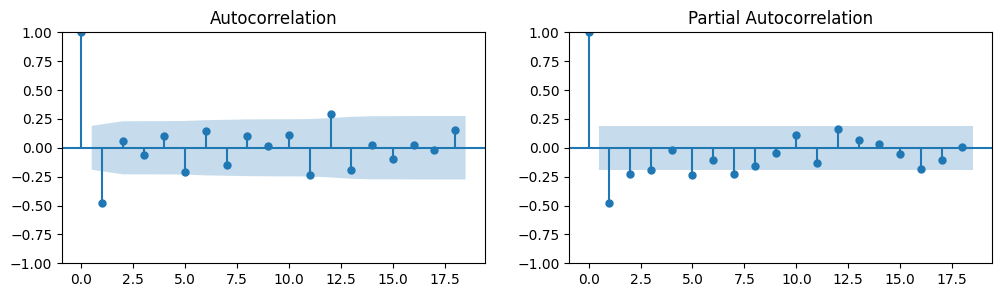

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,106.0,0.026007,0.510695,-1.753218,-0.194914,0.071373,0.317619,1.564512,-0.488120,2.634543
d_ln_open_price,106.0,0.044073,0.182874,-0.391159,-0.070248,0.034404,0.145015,0.671024,0.440641,0.789578


In [ ]:
exploratory_analysis(monthly_data)

In [ ]:
perform_cointegration_test(monthly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -6.959885964112277
p-value: 1.0689059365972825e-08
Critical values: [-4.00378481 -3.39494029 -3.08508909]
The series are likely co-integrated.


(-6.959885964112277,
 1.0689059365972825e-08,
 array([-4.00378481, -3.39494029, -3.08508909]))

# Weekly

Weekly Data Model Estimation:
Mean Baseline MAE: 0.05440187421166778
Previous Value Baseline MAE: 0.06463647144271249
Top 1 Model: ARIMA(1,0,1), MAE: 0.06845099123809194
{'MSE': 0.004727385900641451, 'RMSE': 0.06875598810752014, 'AIC': -819.4796155250067, 'BIC': -799.9392008341621, 'Ljung-Box': 0.35841018052414647, 'Durbin-Watson': 1.994808783218984, 'Jarque-Bera': 0.001234527983135463, 'Shapiro-Wilk': 0.0008101329440250993, 'White Test': 0.8067458903720959}


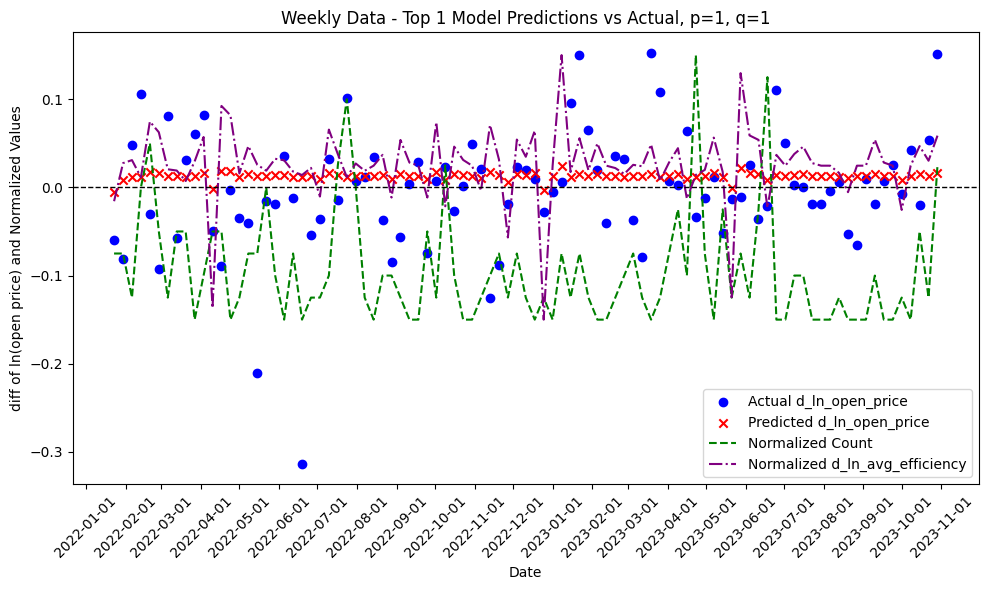

Top 2 Model: ARIMA(1,0,2), MAE: 0.06873198818746276
{'MSE': 0.004731578028549743, 'RMSE': 0.0687864668997452, 'AIC': -817.790231050386, 'BIC': -794.3417334213724, 'Ljung-Box': 0.4039942586760127, 'Durbin-Watson': 1.9944744383140565, 'Jarque-Bera': 0.0010629475280143049, 'Shapiro-Wilk': 0.0007193509954959154, 'White Test': 0.8180336264834451}


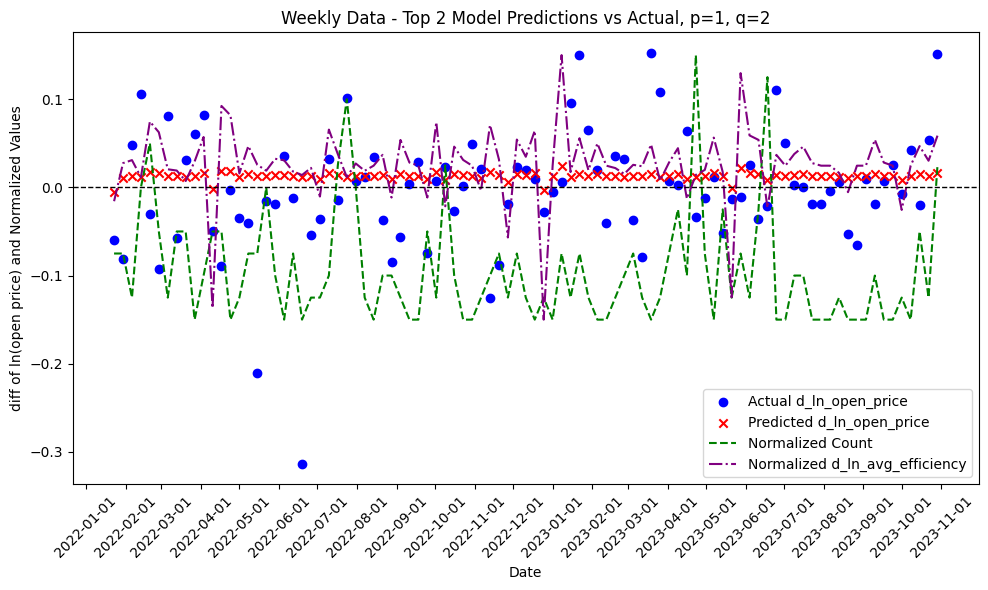

Top 3 Model: ARIMA(2,0,1), MAE: 0.08112456124911531
{'MSE': 0.004726376864070731, 'RMSE': 0.06874864990725804, 'AIC': -817.4536043732408, 'BIC': -794.0051067442272, 'Ljung-Box': 0.3613808834175467, 'Durbin-Watson': 1.9915803947425028, 'Jarque-Bera': 0.0012445681637068206, 'Shapiro-Wilk': 0.0008210378000512719, 'White Test': 0.804267789118364}


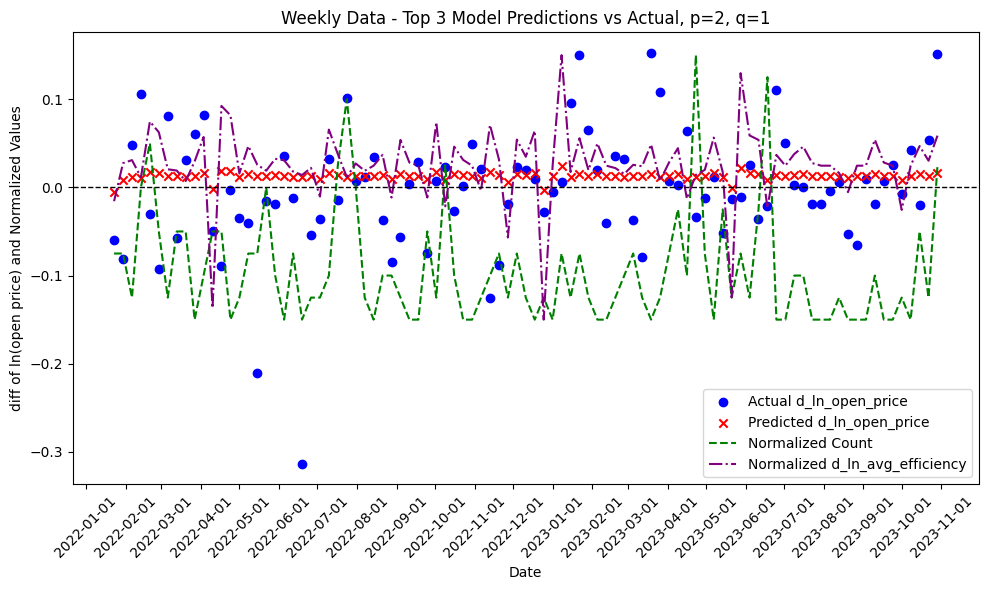

In [ ]:
print("Weekly Data Model Estimation:")
# model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', ratio=0.8)
model_estimation(weekly_data, range(1, 3, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [ ]:
print("Stationarity check for weekly data")
check_stationarity(weekly_data['d_ln_open_price'])
check_stationarity(weekly_data['d_ln_avg_efficiency'])

Stationarity check for weekly data
ADF Statistic: -15.002441
p-value: 0.000000
Series is stationary
ADF Statistic: -7.969454
p-value: 0.000000
Series is stationary


Distribution Plot:


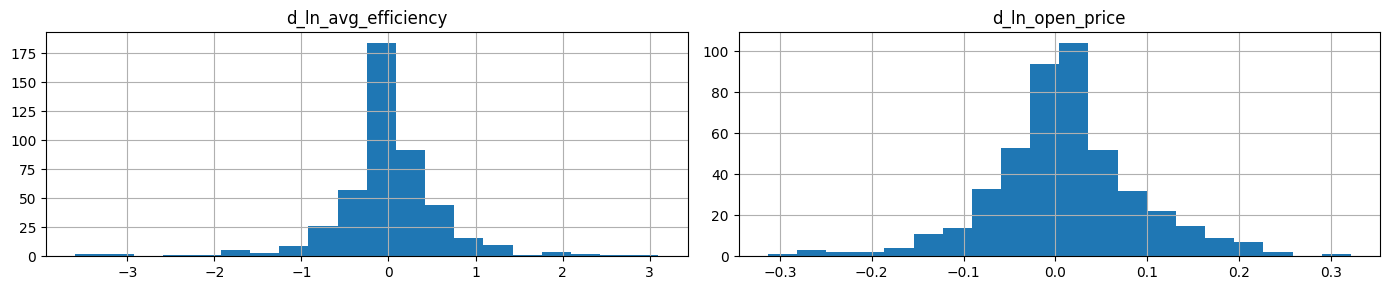

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


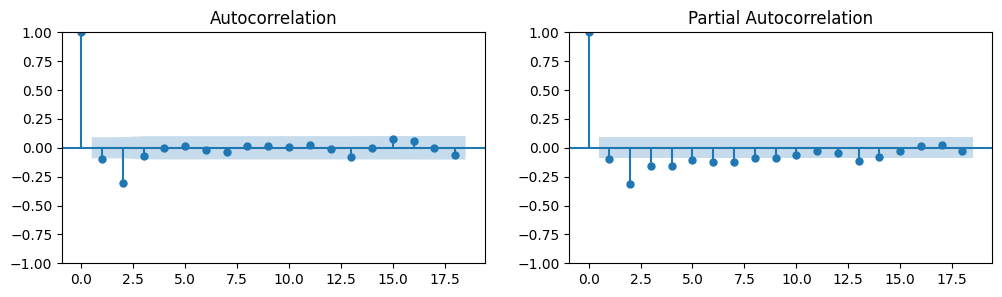

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,461.0,0.008091,0.659471,-3.598365,-0.194234,0.000000,0.273292,3.100336,-0.684736,7.325169
d_ln_open_price,461.0,0.009966,0.081107,-0.313285,-0.030217,0.007147,0.049662,0.321963,-0.049507,1.764682


In [ ]:
exploratory_analysis(weekly_data)

In [ ]:
perform_cointegration_test(weekly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -15.017830656644332
p-value: 8.777730157970857e-27
Critical values: [-3.92040692 -3.34944507 -3.05368285]
The series are likely co-integrated.


(-15.017830656644332,
 8.777730157970857e-27,
 array([-3.92040692, -3.34944507, -3.05368285]))

# Daily

In [ ]:
print("Daily Data Model Estimation:")
# model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

Daily Data Model Estimation:


In [ ]:
print("Stationarity check for daily data")
check_stationarity(daily_data['d_ln_open_price'])
check_stationarity(daily_data['d_ln_avg_efficiency'])

In [ ]:
exploratory_analysis(daily_data)

In [ ]:
perform_cointegration_test(daily_data, 'd_ln_open_price', 'd_ln_avg_efficiency')